In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

# 1. load img data

In [12]:
datapath = './datasets/'
filename = 'miguel_passive8x4.mat'
filepath = os.path.join(datapath, filename)
# load matlab mat file
from scipy.io import loadmat
img_mat = loadmat(filepath)
img = img_mat['img'].astype(np.float32)
istim = img_mat['istim']
img = np.transpose(img, (2, 0, 1))
print('img:', img.shape, img.min(), img.max())
print('istim:', istim.shape, istim.min(), istim.max())

img: (32, 150, 600) 0.0 255.0
istim: (1, 44800) 1 32


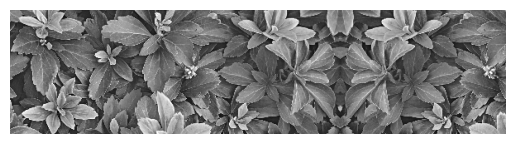

In [11]:
plt.imshow(img[0], cmap='gray')
plt.axis('off')
plt.show()

# load model

In [21]:
from approxineuro.models.grayscale_alexnet import Feature_AlexNet
from approxineuro.models.grayscale_vgg import vgg
from approxineuro.alexnet import AlexNet
import torch
from torch.hub import load_state_dict_from_url
import os

model_list = ['RGB(224)', 'Grayscale(224)', 'Grayscale(128)', 'Grayscale(64)', 'VGG_Grayscale(64)']

model_path = './pretrained_models/'
model_dict = {'RGB(224)': None,
              'Grayscale(224)': f'{model_path}/model_best_grayscale_224.pth.tar',
              'Grayscale(128)': f'{model_path}/model_best_grayscale_128.pth.tar',
              'Grayscale(64)': f'{model_path}/model_best_grayscale_64.pth.tar',
              'VGG_Grayscale(64)': f'{model_path}/model_best_grayscale_vgg_64_pretrained.pth.tar'}

model_id = 2          
model_name = model_list[model_id]
print('loading alexnet pretrained model: ', model_name)
if model_name == 'RGB(224)':
    state_dict = load_state_dict_from_url('https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth')
    model = AlexNet()
    # add new axis to image
    img = img[:, np.newaxis, :, :]
    # repeat 3 times
    img = np.repeat(img, 3, axis=1)
    print(f'reshape image to {img.shape}')
else:
    checkpoint = torch.load(model_dict[model_name])
    epoch = checkpoint['epoch']
    best_acc1 = checkpoint['best_acc1']
    print('best accuracy(top 1), epoch {}: {:.2f}%'.format(epoch, best_acc1))
    state_dict = checkpoint['state_dict']
    print('initializing model')
    if 'VGG' in model_name:
        model = vgg()
    else:
        model = Feature_AlexNet()

model_dict = model.state_dict()
pretrained_keys = list(state_dict.keys())
model_keys = list(model_dict.keys())
for i in range(len(model_keys)):
    model_dict[model_keys[i]].copy_(state_dict[pretrained_keys[i]])
model.load_state_dict(model_dict)

loading alexnet pretrained model:  Grayscale(128)
best accuracy(top 1), epoch 82: 45.39%
initializing model


<All keys matched successfully>

In [22]:
from torchvision import transforms
model.eval()
if torch.cuda.is_available():
    model.to('cuda')
    print('sent model to GPU')

sent model to GPU


In [23]:
from approxineuro.ann_utils import torch_batch_transform
if model_name == 'RGB(224)':
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
    rgb_flag = True
else:
    normalize = transforms.Normalize(mean=[0.445], std=[0.269])
    preprocess = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        # transforms.Resize(33),
        # transforms.CenterCrop([300, 150]),
        transforms.ToTensor(),
        normalize,
    ])
    rgb_flag = False

ann_fvs = []

n_stim = len(img)
batch_size = 100
for k in range(0, n_stim, batch_size):
    end = min(k+batch_size, len(img))
    img_batch = img[k:end]
    # get feature
    img_batch = torch_batch_transform(preprocess, img_batch, rgb_flag)
    img_batch = img_batch.to('cuda')
    output = model(img_batch)
    
    for layer_id in range(6):
        batch_feature = model.features[layer_id].detach().cpu().numpy()
        if k == 0:
            ann_fvs.append(batch_feature.copy())
        else:
            ann_fvs[layer_id] = np.vstack([ann_fvs[layer_id], batch_feature])
        # print('{} {} feature shape: '.format('conv', layer_id+1), ann_fvs[layer_id].shape)

In [24]:
ann_fvs_all = []
for layer_id in range(6):
    ann_fvs_all.append(ann_fvs[layer_id].reshape(n_stim, -1))
    print('{} {} feature shape: '.format('conv', layer_id+1), ann_fvs[layer_id].shape, ann_fvs[layer_id].min(), ann_fvs[layer_id].max())
ann_fvs_all = np.hstack(ann_fvs_all)
# del model

conv 1 feature shape:  (32, 64, 17, 74) 0.0 16.61017
conv 2 feature shape:  (32, 192, 8, 36) 0.0 33.67876
conv 3 feature shape:  (32, 384, 8, 36) 0.0 36.316086
conv 4 feature shape:  (32, 256, 8, 36) 0.0 31.258343
conv 5 feature shape:  (32, 256, 3, 17) 0.0 29.374472
conv 6 feature shape:  (32, 9216) 0.0 27.271969


In [25]:
save_dict = {}
for layer_id in range(5):
    save_dict[f'conv{layer_id+1}'] = ann_fvs[layer_id]
    print(f'conv{layer_id+1}: ', ann_fvs[layer_id].shape)
save_dict['fc'] = ann_fvs[5]
print('fc: ', ann_fvs[5].shape)
# save_dict['istim'] = istim

save_path = './data'
fname = filename.split('.')[0]
save_name = f'ann_fvs_{model_name}_{fname}.npz'
save_file_path = os.path.join(save_path, save_name)
np.savez(save_file_path, **save_dict)
print(f'saved to {save_file_path}')

conv1:  (32, 64, 17, 74)
conv2:  (32, 192, 8, 36)
conv3:  (32, 384, 8, 36)
conv4:  (32, 256, 8, 36)
conv5:  (32, 256, 3, 17)
fc:  (32, 9216)
saved to ./data/ann_fvs_Grayscale(128)_miguel_passive8x4.npz
